# **Vehicle Detection for Autonomous Cars** 
***

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Test Images

Built my pipeline to work on the images in the directory "test_images"

In [3]:
import os

# print test images file name
test_images_names = os.listdir("test_images/")
print(test_images_names)

['test1.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']


### Read in the Test Image
I'll test each step of my pipeline on the following test image

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


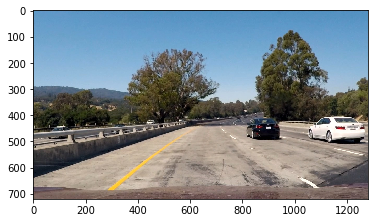

In [4]:
#reading in an image
test_image = mpimg.imread('test_images/test1.jpg')

# printing out some stats and plotting
print('This image is:', type(test_image), 'with dimesions:', test_image.shape)
plt.imshow(test_image) 

### Draw Boxes Manually to Prototype
This function takes an image, a list of bounding boxes, and optional color tuple and line thickness as inputs and then draws boxes in that color on the output

In [19]:
def draw_boxes(img, bboxes, color=(255, 0, 0), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    for bbox in bboxes:
            cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # return the image copy with boxes drawn
    return draw_img 

Test drawing boxes on the test image

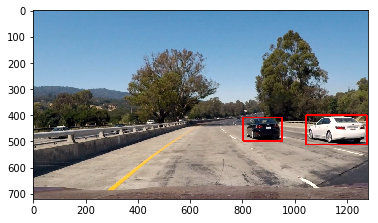

In [21]:
# manually set the coordinates of the vehicule boxes 
bboxes = [((951, 498), (803, 409)), ((1276, 512), (1043, 401))]

result = draw_boxes(test_image, bboxes)
plt.imshow(result)